In [2]:
import numpy as np
import uproot as up
import pandas as pd
import matplotlib.pyplot as plot
from scipy.stats import norm
from scipy.optimize import curve_fit
import sympy
from IPython.display import clear_output
import math
import time
import util
#My imports
from util import PVect,get_layer,create_layer_map,theta_func,phi_func,findBin,bin_percent_theta_phi, train, test, create_data, create_data_depth,p_func, calculate_num_pixels,Classifier,plot_roc_curve

Using device cuda:0


In [3]:
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import torch.optim as optim

from tqdm import tqdm

In [4]:
#roc-curve calculations
from sklearn.metrics import roc_auc_score, roc_curve

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [5]:
particle = "mu"
energy = "5"
color_dict = {
    "pi" : "red",
    "mu" : "blue"
}
part_dict = {
    -211 : 1,
    13 : 0
}

Input:
1. \# hits per layer
2. total energy per layer

56 total

* 0-27: pixels per layer
* 28: primary momentum
* 29: layers traversed
* 30: label (don't include in sample)

Total length: 31
Sample length: 30

In [6]:
layer_map, super_layer_map = create_layer_map()

In [7]:
def inverse(x,a,b,c):
    return a  / (x + b) + c
def calculate_num_pixels_z_dependence(energy_dep, z_hit):
    efficiency = inverse(770 - z_hit,494.98,9.9733,-0.16796)
    return 10 * energy_dep * (1000 * 1000) * efficiency

In [8]:
def create_data_depth(uproot_path, file_num = 0, particle = "pion"):
    events = up.open(uproot_path)

    x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
    z_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.z"].array(library='np')
    EDep_branch = events["HcalBarrelHits.EDep"].array(library='np')
    Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')
    PDG_branch = events["MCParticles.PDG"].array(library='np')

    x_momentum_branch = events["MCParticles.momentum.x"].array(library='np')
    y_momentum_branch = events["MCParticles.momentum.y"].array(library='np')
    z_momentum_branch = events["MCParticles.momentum.z"].array(library='np')
    num_events = len(x_pos_branch)
    num_features = 56
    num_layers = 28

    hits_per_layer = np.zeros((num_events,28))
    EDep_per_layer = np.zeros((num_events,28))
    pixels_per_layer = np.zeros((num_events,28))
    label = np.zeros((num_events,1))
    layers_traversed = np.zeros((num_events,1))
    primary_momentum = np.zeros((num_events,1))
    primary_theta = np.zeros((num_events,1))
    primary_phi = np.zeros((num_events,1))
    skip_count = 0
    for event_idx in range(len(x_pos_branch)):
        if(not event_idx % (len(x_pos_branch) // 10)):
            clear_output(wait = True)
            print(f"on event #{event_idx} for file #{file_num} for {particle}")
        event_x_pos = x_pos_branch[event_idx]
        event_EDep = EDep_branch[event_idx]
        
        current_px = x_momentum_branch[event_idx][0]
        current_py = y_momentum_branch[event_idx][0]
        current_pz = z_momentum_branch[event_idx][0]
        current_theta = theta_func(current_px,current_py,current_pz)
        current_phi = phi_func(current_px,current_py,current_pz)

        primary_momentum[event_idx][0] = p_func(current_px,current_py,current_pz)
        primary_theta[event_idx][0] = theta_func(current_px,current_py,current_pz)
        primary_phi[event_idx][0] = phi_func(current_px,current_py,current_pz)
        #for each event, loop over the particles to find mu/pi
        hit_layers = np.zeros(28)
        for hit_idx in range(len(event_x_pos)):
            current_x_pos = event_x_pos[hit_idx]
            current_EDep = event_EDep[hit_idx]
            current_z_pos = z_pos_branch[event_idx][hit_idx]

            layer_hit = get_layer(current_x_pos,super_layer_map)
            if(layer_hit == -1):
                skip_count += 1
                continue
            hit_layers[layer_hit] += 1
            EDep_per_layer[event_idx][layer_hit] += current_EDep
            hits_per_layer[event_idx][layer_hit] += 1
            pixels_per_layer[event_idx][layer_hit] += calculate_num_pixels_z_dependence(current_EDep,current_z_pos)
        for i in range(29):
            if(i == 28):
                layers_traversed[event_idx][0] = 28
                break
            curr_pixels = pixels_per_layer[event_idx][i]
            if(curr_pixels < 2):
                layers_traversed[event_idx][0] = i
                break
        label[event_idx][0] = part_dict[PDG_branch[event_idx][0]]
    return torch.cat((torch.tensor(pixels_per_layer),torch.tensor(primary_momentum),torch.tensor(primary_theta),torch.tensor(primary_phi),torch.tensor(layers_traversed),torch.tensor(label)),1)

In [9]:
for i in range(10,14):
    if(i == 10):
        mu_data = create_data_depth(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/mu/variation_10kevents_file_{i}.edm4hep.root:events",file_num = i, particle = "muon")
        pi_data = create_data_depth(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/pi/variation_10kevents_file_{i}.edm4hep.root:events",file_num=i,particle="pion")
    else:
        add_mu = create_data_depth(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/mu/variation_10kevents_file_{i}.edm4hep.root:events",file_num = i, particle = "muon")
        mu_data = torch.cat((mu_data, add_mu),0)
        add_pi = create_data_depth(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/pi/variation_10kevents_file_{i}.edm4hep.root:events",file_num=i,particle="pion")
        pi_data = torch.cat((pi_data, add_pi),0)
for i in range(14,15):
    if(i == 14):
        test_mu_data = create_data_depth(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/mu/variation_10kevents_file_{i}.edm4hep.root:events",file_num = i, particle = "muon")
        test_pi_data = create_data_depth(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/pi/variation_10kevents_file_{i}.edm4hep.root:events",file_num=i,particle="pion")
    else:
        test_add_mu = create_data_depth(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/mu/variation_10kevents_file_{i}.edm4hep.root:events",file_num = i, particle = "muon")
        test_mu_data = torch.cat((test_mu_data, test_add_mu),0)
        test_add_pi = create_data_depth(uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_18/variation_sector_scint_uniform/pi/variation_10kevents_file_{i}.edm4hep.root:events",file_num=i,particle="pion")
        test_pi_data = torch.cat((test_pi_data, test_add_pi),0)

on event #9000 for file #14 for pion


In [10]:
dataset = torch.cat((mu_data,pi_data),)
indexes = torch.randperm(dataset.shape[0])
dataset_shuffled = dataset[indexes]

test_dataset = torch.cat((test_mu_data,test_pi_data),)
test_indexes = torch.randperm(test_dataset.shape[0])
test_dataset_shuffled = test_dataset[test_indexes]

In [11]:
classifier = Classifier(num_layers = 10, input_size=28, hidden_dim = 600).to(device)

optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4, weight_decay=1e-5)
num_epochs_classifier = 15

In [12]:
loss_hist = train(classifier, dataset_shuffled,optimizer, num_epochs = 5)

Training epoch #0


  0%|          | 0/800 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
plot.plot(loss_hist)

In [ ]:
test_Y,probs_Y = test(classifier, test_dataset_shuffled,return_outputs = True)

../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [2,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [3,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [4,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [5,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [6,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_f

In [ ]:
plot_roc_curve(test_Y,probs_Y)

# Cut classification

In [66]:
num_bins = 20
energy_bin_edges = np.linspace(0,10,num_bins + 1)
# assuming 'tensor' is your input tensor
binned_tensor = [torch.ones((1,33), dtype=dataset_shuffled.dtype) * -99 for i in range(num_bins)]

In [67]:
energy_bin_edges

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ])

In [68]:
for event in range(dataset_shuffled.shape[0]):
    bin_num = findBin(dataset_shuffled[event,28],energy_bin_edges)
    if(binned_tensor[bin_num][0,32] == -99):
        binned_tensor[bin_num][0] = dataset_shuffled[event]
    else:
        binned_tensor[bin_num] = torch.cat((binned_tensor[bin_num],dataset_shuffled[event].unsqueeze(0)))

In [69]:
pi_energy_binned = []
mu_energy_binned = []
for i in range(len(binned_tensor)):
    pi_bin_mask = binned_tensor[i][:,32] == part_dict[-211]
    pi_energy_binned.append(binned_tensor[i][pi_bin_mask])
    mu_bin_mask = binned_tensor[i][:,32] == part_dict[13]
    mu_energy_binned.append(binned_tensor[i][mu_bin_mask])

In [70]:
pi_energy_binned[0].shape

torch.Size([349, 33])

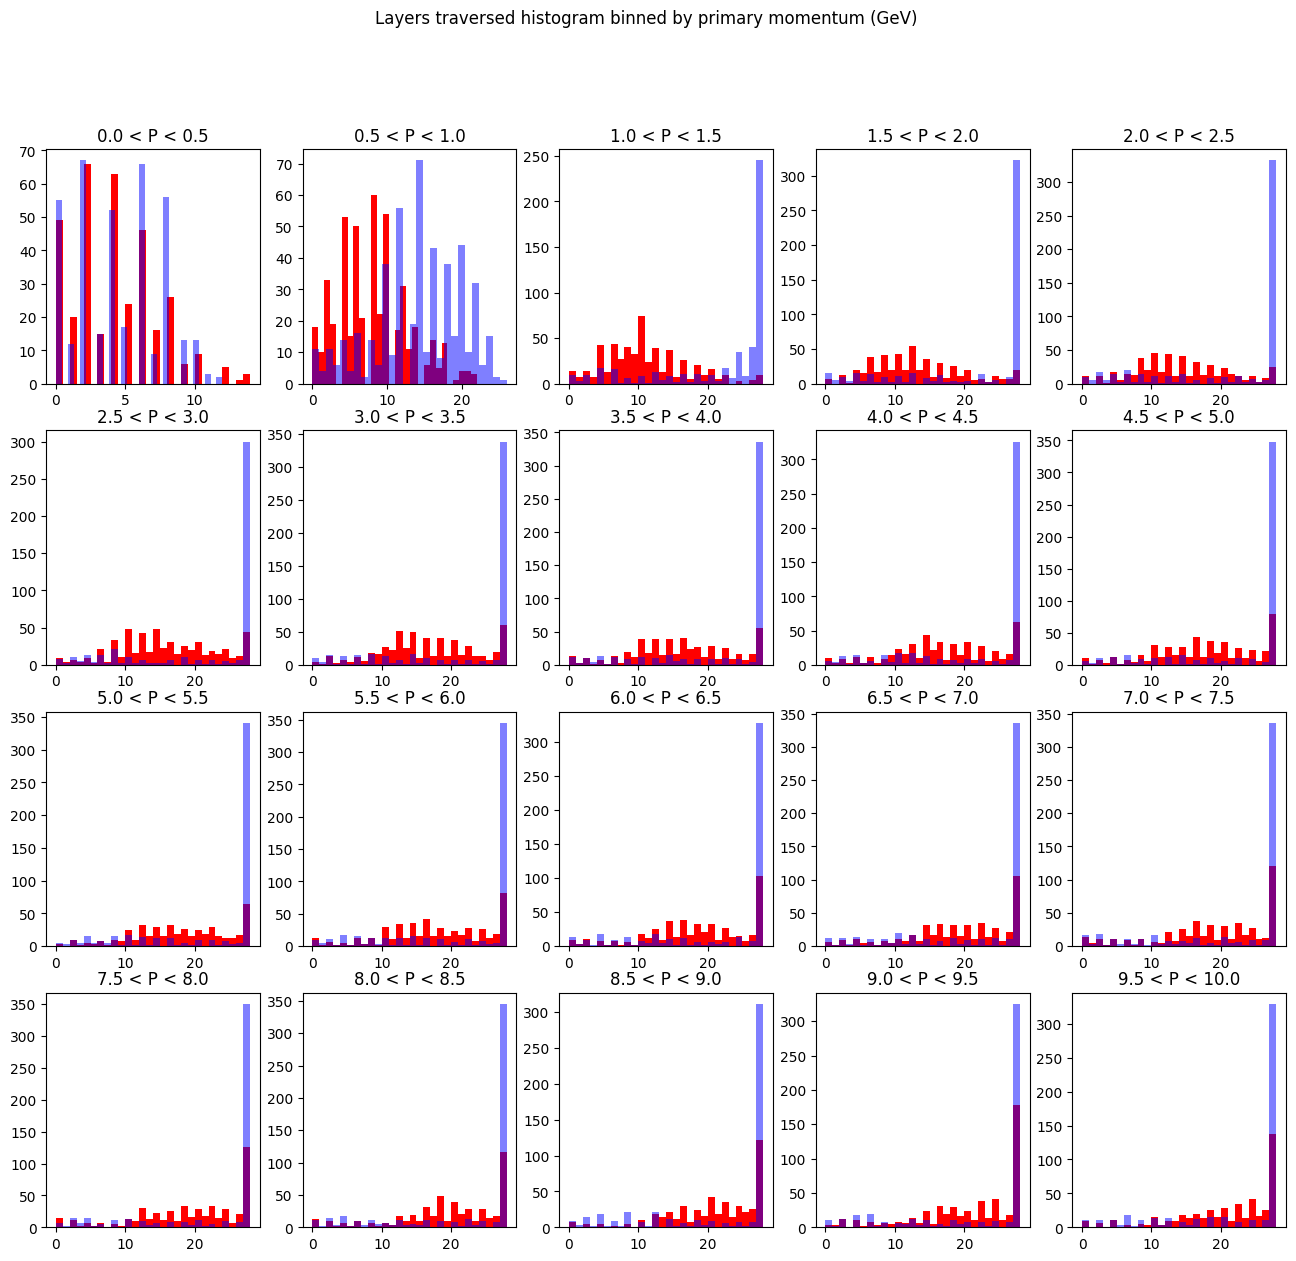

In [73]:
fig, axs = plot.subplots(4,5,figsize = (16,14))
fig.suptitle("Layers traversed histogram binned by primary momentum (GeV)")
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].set_title(f"{energy_bin_edges[i * 5 + j]} < P < {energy_bin_edges[i * 5 + j + 1]}")
        axs[i,j].hist(pi_energy_binned[i * 5 + j][:,31],bins = 28, color = 'r')
        axs[i,j].hist(mu_energy_binned[i * 5 + j][:,31],bins = 28,alpha = 0.5, color = 'b')

In [76]:
mu_correct = np.empty((num_bins,28))
pi_correct = np.empty((num_bins,28))

for i in range(num_bins):
    for j in range(28):
        mu_correct_mask = mu_energy_binned[i][:,31] > j
        mu_correct_set = mu_energy_binned[i][mu_correct_mask]
        mu_correct[i][j]  = mu_correct_set.shape[0] / mu_energy_binned[i].shape[0]
        
        pi_correct_mask = pi_energy_binned[i][:,31] <= j
        pi_correct_set = pi_energy_binned[i][pi_correct_mask]
        pi_correct[i][j]  = pi_correct_set.shape[0] / pi_energy_binned[i].shape[0]

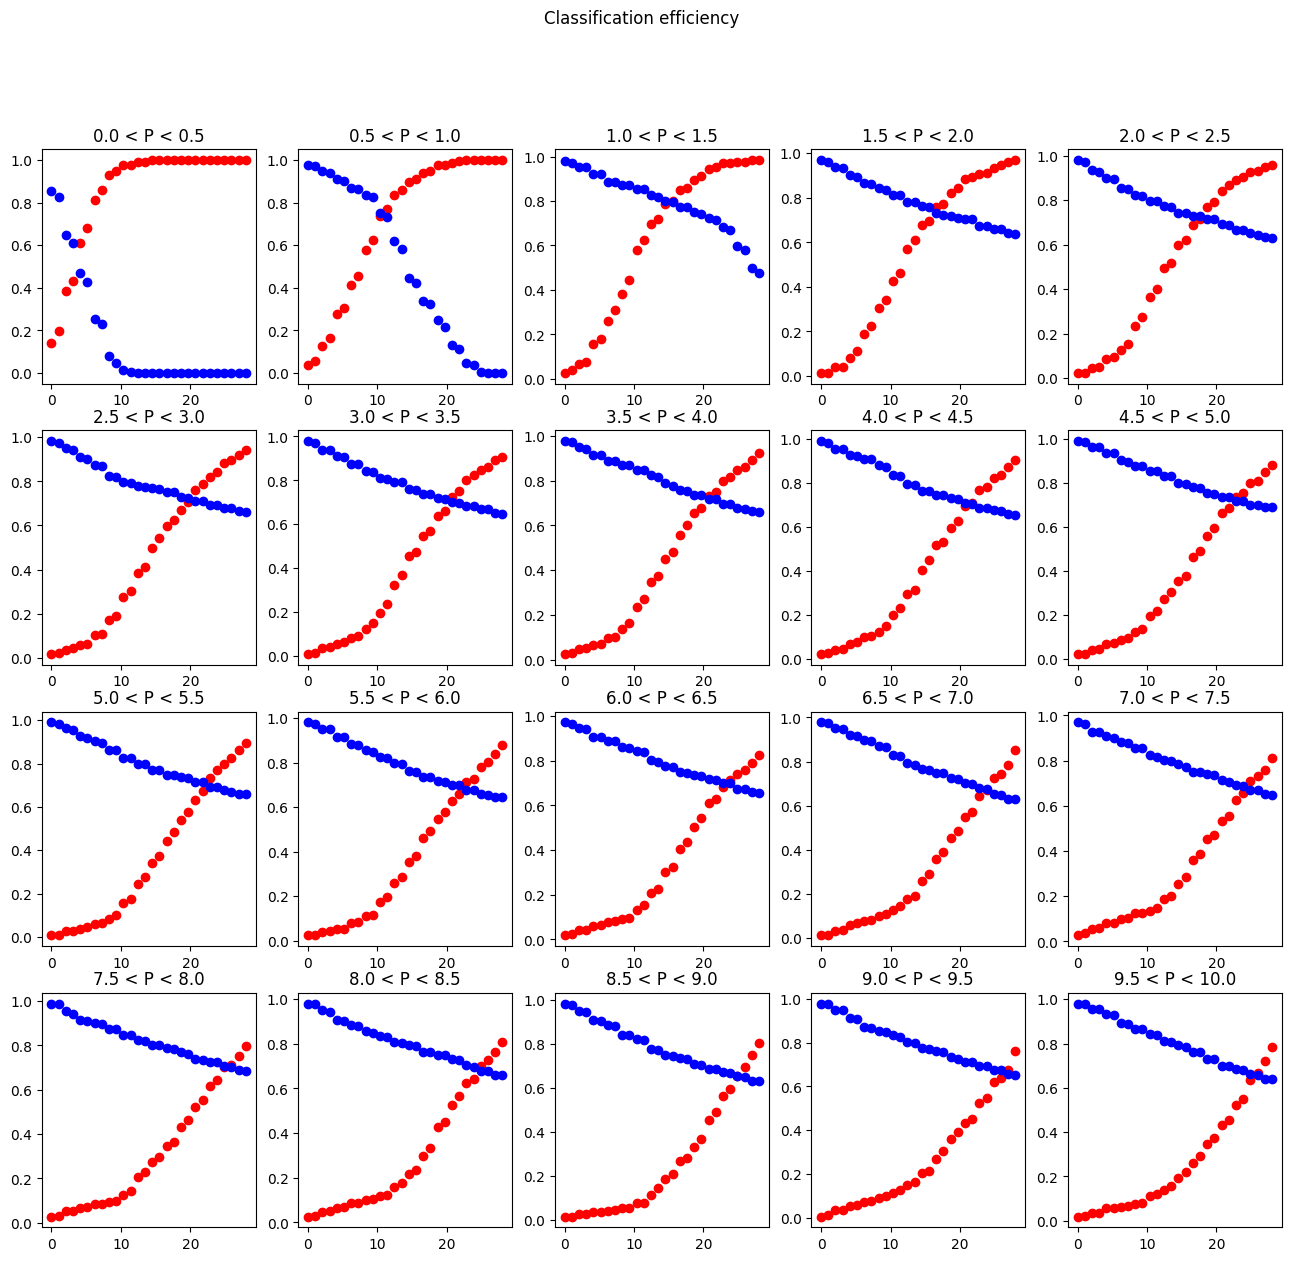

In [78]:
fig, axs = plot.subplots(4,5,figsize = (16,14))
fig.suptitle("Classification efficiency")
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].set_title(f"{energy_bin_edges[i * 5 + j]} < P < {energy_bin_edges[i * 5 + j + 1]}")
        axs[i,j].scatter(np.linspace(0,28,28),pi_correct[i * 5 + j], color = 'r')
        axs[i,j].scatter(np.linspace(0,28,28),mu_correct[i * 5 + j], color = 'b')